<a href="https://colab.research.google.com/github/nunorfidalgo/AD2425_TP/blob/main/AD2425_TP_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup, Version check and Common imports


In [ ]:
# Python ≥3.8 is required
import sys
assert sys.version_info >= (3, 5)


# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

from tensorflow import keras
from tensorflow.keras import layers

import kagglehub
import pathlib
import pandas as pd

from warnings import filterwarnings
filterwarnings('ignore')
from keras.preprocessing.image import load_img, img_to_array

# to make this notebook's output stable across runs
np.random.seed(42)

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

print('Python version: ', sys.version_info)
print('TF version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('GPU is', 'available' if tf.config.list_physical_devices('GPU') else 'NOT AVAILABLE')
tf.test.is_gpu_available()

Python version:  sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
TF version:  2.18.0
Keras version:  3.8.0
GPU is available


I0000 00:00:1745649508.644679     389 gpu_device.cc:2022] Created device /device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


True

# Vars

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 150
EPOCHS=20

# Data Fetching and Loading

In [ ]:
# Download the Intel Image Classification dataset: https://www.kaggle.com/datasets/puneet6060/intel-image-classification/
path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", path)

Path to dataset files: /home/rafeiro/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


# List paths

In [ ]:
seg_pred_path = (path + '/seg_pred/seg_pred/')
print("Path to seg_pred files:", seg_pred_path)

seg_test_path = (path + '/seg_test/seg_test/')
print("Path to seg_test files:", seg_test_path)

seg_train_path = (path + '/seg_train/seg_train/')
print("Path to seg_train files:", seg_train_path)

Path to seg_pred files: /home/rafeiro/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_pred/seg_pred/
Path to seg_test files: /home/rafeiro/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_test/seg_test/
Path to seg_train files: /home/rafeiro/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_train/seg_train/


# Count images of each directory

In [ ]:
seg_pred_dir = pathlib.Path(seg_pred_path)
seg_pred_img_count = len(list(seg_pred_dir.glob('*.jpg')))
print("Count pred images: ", seg_pred_img_count)

seg_test_dir = pathlib.Path(seg_test_path)
seg_test_img_count = len(list(seg_test_dir.glob('*/*.jpg')))
print("Count test images: ", seg_test_img_count)

seg_train_dir = pathlib.Path(seg_train_path)
seg_train_img_count = len(list(seg_train_dir.glob('*/*.jpg')))
print("Count train images: ", seg_train_img_count)

Count pred images:  7301
Count test images:  3000
Count train images:  14034


# Creation of the dataset objects

 The images in the folders are not divided in train and validation datasets

 The following code divides samples into 70% training and 30% validation.

 No test set is created


In [ ]:
# training dataset - 70%
train_ds = keras.preprocessing.image_dataset_from_directory(
    seg_train_dir,
    validation_split=0.3,
    subset="training",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

# validition dataset - 30%
val_ds = keras.preprocessing.image_dataset_from_directory(
    seg_train_dir,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

# test dataset
test_ds = keras.preprocessing.image_dataset_from_directory(
    seg_test_dir,
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names

train_ds = train_ds.cache().prefetch(1)
val_ds = val_ds.cache().prefetch(1)
test_ds = test_ds.cache().prefetch(1)

Found 14034 files belonging to 6 classes.
Using 9824 files for training.
Found 14034 files belonging to 6 classes.
Using 4210 files for validation.
Found 3000 files belonging to 6 classes.


# Dataset detailed information

In [ ]:
print('Nr. of classes: ', len(class_names))
print('Classes: ', class_names)

# Cardinality
print('Cardinalidade Treino: ', train_ds.cardinality().numpy())
print('Cardinalidade Validacão: ', val_ds.cardinality().numpy())
print('Cardinalidade Teste: ', test_ds.cardinality().numpy())

Nr. of classes:  6
Classes:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Cardinalidade Treino:  307
Cardinalidade Validacão:  132
Cardinalidade Teste:  94


# Count the number of images in each class


## in train dir:

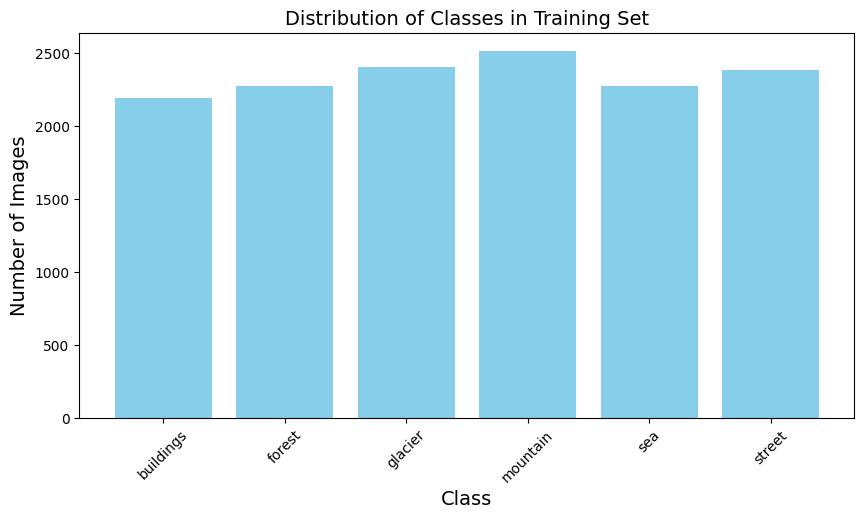

In [ ]:
class_counts = {class_name: len(os.listdir(os.path.join(seg_train_dir, class_name))) for class_name in class_names}

# Plot the distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Training Set')
plt.xticks(rotation=45)
plt.show()

## in test dir:

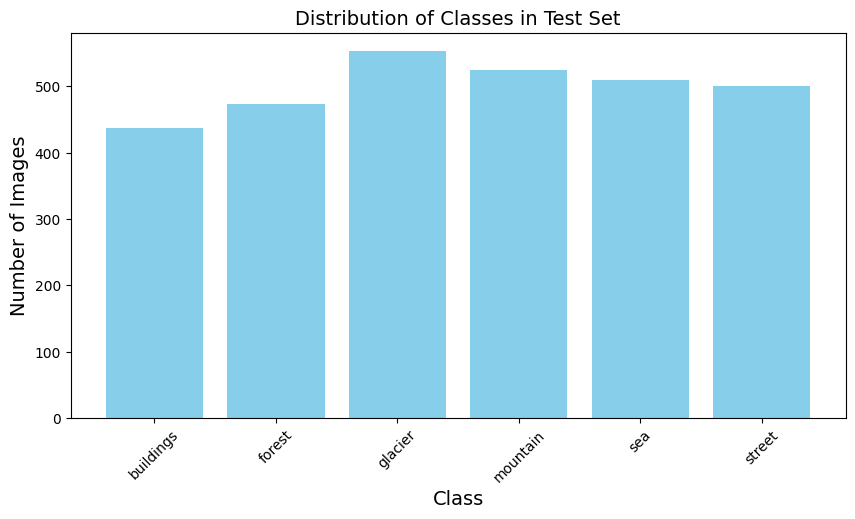

In [ ]:
class_counts = {class_name: len(os.listdir(os.path.join(seg_test_dir, class_name))) for class_name in class_names}

# Plot the distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Test Set')
plt.xticks(rotation=45)
plt.show()

# Visualize a few examples

2025-04-26 07:38:29.989506: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


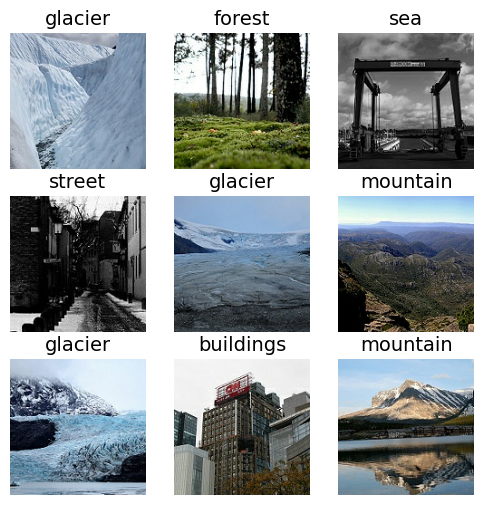

In [ ]:
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy()/255.)
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Data Augmentation


In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical'),
    layers.RandomRotation(factor=0.3),
    layers.RandomShear(0.2),
    layers.RandomZoom(0.2),
])

# Visualize examples of augmented images


2025-04-26 07:38:30.310550: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-26 07:38:30.801681: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


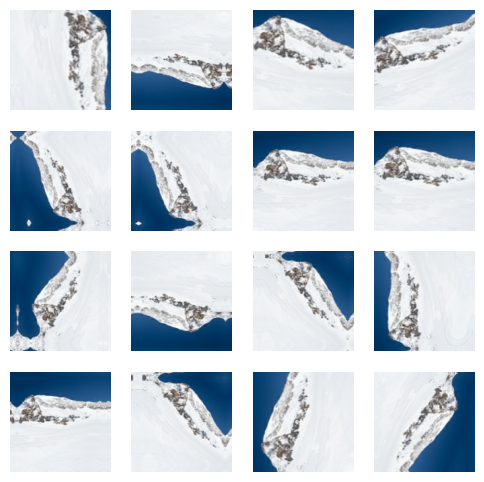

In [ ]:
plt.figure(figsize=(6, 6))
for images, _ in train_ds.take(1):
  for i in range(16):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[0].numpy()/255.)
    plt.axis("off")

# Model Xception for transfer learning:




In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Get Xception and freeze all layers of Xception
base_model = keras.applications.Xception(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False
    )
base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)

outputs = layers.Dense(6)(x)

model = keras.Model(inputs, outputs)

# Model compilation

In [ ]:
base_learning_rate = 0.0001
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Check the limit for the maximum number of parameters

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,997,166 (80.10 MB)

 Trainable params: 135,686 (530.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

# Test the data before training to see the accuracy

In [ ]:
model.evaluate(test_ds)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.1954 - loss: 1.8819


[1.880341649055481, 0.1966666728258133]

# Let's train the model for X epochs with EarlyStopping

## Using EarlyStopping, when the val_accuracy has not improved after 10 epochs, stop training.

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                        mode='max',restore_best_weights=True,patience=10)

In [ ]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[early_stopping])

Epoch 1/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.2602 - loss: 1.7954 - val_accuracy: 0.7563 - val_loss: 1.0532
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5248 - loss: 1.2146 - val_accuracy: 0.7876 - val_loss: 0.6910
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.6241 - loss: 0.9667 - val_accuracy: 0.8010 - val_loss: 0.5735
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.6730 - loss: 0.8616 - val_accuracy: 0.8154 - val_loss: 0.5301
Epoch 5/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6835 - loss: 0.8180 - val_accuracy: 0.8202 - val_loss: 0.4948
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.7100 - loss: 0.7690 - val_accuracy: 0.8242 - val_loss: 0.4809
Epoch 7/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.7170 - loss: 0.7472 - val_accuracy: 0.8273 - val_loss: 0.4636
Epoch 8/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.7201 - loss: 0.7338 - 

# Visualize results (both accuracy and loss) Model Xception (trainable=false)

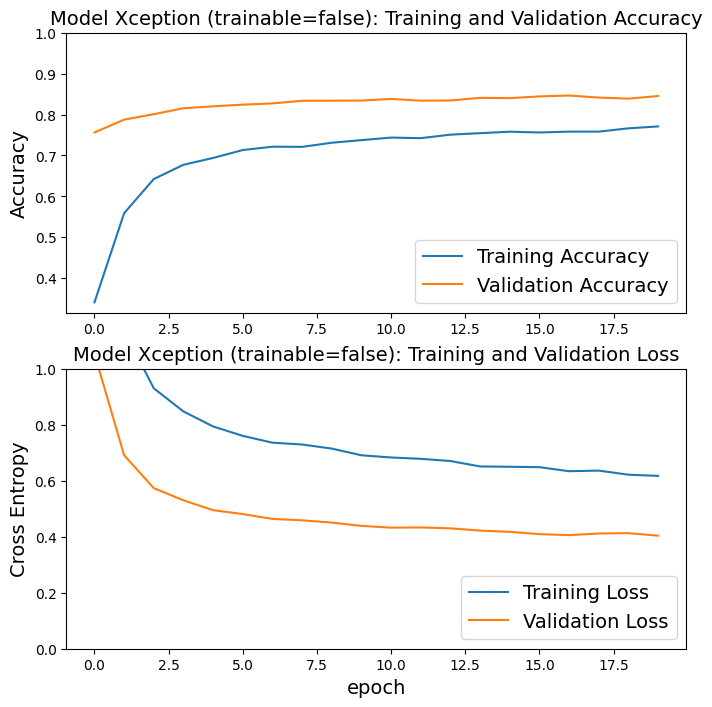

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Model Xception (trainable=false): Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Model Xception (trainable=false): Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

 Now let's test it again

In [ ]:
model.evaluate(test_ds)

# It's good now. But we can make it better.

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8481 - loss: 0.4197


[0.4204082489013672, 0.8423333168029785]

# Fine tuning

In [ ]:
print("Number of Xception layers:", len(base_model.layers))

Number of Xception layers: 132


# Unfreeze the top layers of the model

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:80]:
  layer.trainable =  False

# Using lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate/10),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# View the network structure and parameters again

In [ ]:
# The trainable parameters change
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,997,166 (80.10 MB)

 Trainable params: 12,841,982 (48.99 MB)

 Non-trainable params: 8,155,184 (31.11 MB)

## Started to fine tune

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                        mode='max',restore_best_weights=True,patience=10)

history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[early_stopping])

Epoch 1/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 33s 75ms/step - accuracy: 0.6521 - loss: 0.9937 - val_accuracy: 0.8131 - val_loss: 0.4897
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.7443 - loss: 0.6788 - val_accuracy: 0.8330 - val_loss: 0.4340
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.7865 - loss: 0.6102 - val_accuracy: 0.8572 - val_loss: 0.3869
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.8007 - loss: 0.5519 - val_accuracy: 0.8648 - val_loss: 0.3625
Epoch 5/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - accuracy: 0.8143 - loss: 0.5305 - val_accuracy: 0.8739 - val_loss: 0.3401
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.8143 - loss: 0.5209 - val_accuracy: 0.8789 - val_loss: 0.3233
Epoch 7/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.8181 - loss: 0.5038 - val_accuracy: 0.8812 - val_loss: 0.3187
Epoch 8/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - accuracy: 0.8299 - loss: 0.4694 - 

# Visualize results (both accuracy and loss) Model Xception Unfreeze the top layers

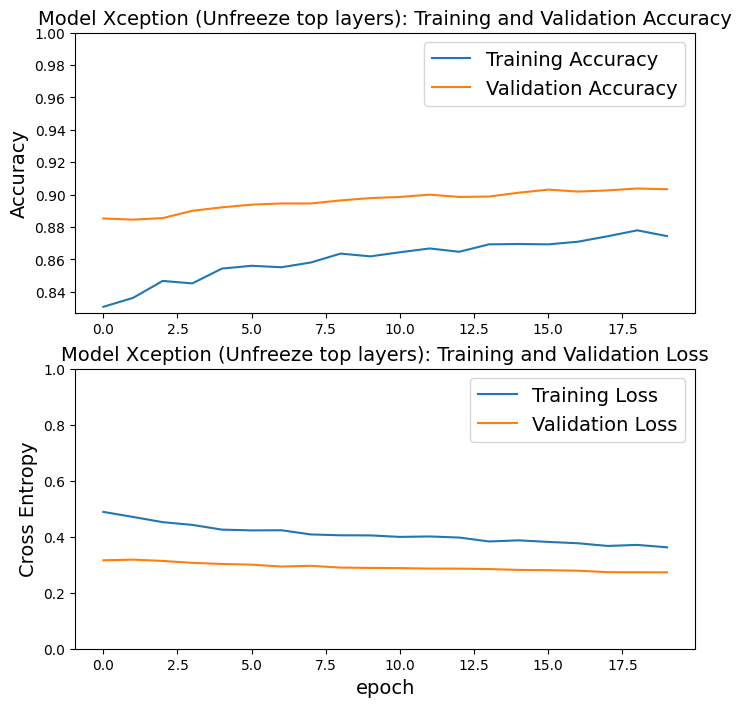

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Model Xception (Unfreeze top layers): Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Model Xception (Unfreeze top layers): Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Let's test it again

In [ ]:
model.evaluate(test_ds)

# Now,it's good,we try to unfreeze all layers to make accuracy better, but that maybe worse.

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9025 - loss: 0.2772


[0.2788870334625244, 0.903333306312561]

# Unfreeze the whole Xception model

In [ ]:
for layer in base_model.layers[:80]:
  layer.trainable =  True

# Using lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate/50),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

## View the network structure and parameters. Trainable parameters are already numerous

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,997,166 (80.10 MB)

 Trainable params: 20,942,638 (79.89 MB)

 Non-trainable params: 54,528 (213.00 KB)

# Started to fine tune again

In [ ]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[early_stopping])

Epoch 1/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 63s 144ms/step - accuracy: 0.8347 - loss: 0.4885 - val_accuracy: 0.8853 - val_loss: 0.3159
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 45s 145ms/step - accuracy: 0.8364 - loss: 0.4695 - val_accuracy: 0.8846 - val_loss: 0.3181
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 42s 136ms/step - accuracy: 0.8454 - loss: 0.4545 - val_accuracy: 0.8855 - val_loss: 0.3135
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - accuracy: 0.8436 - loss: 0.4386 - val_accuracy: 0.8900 - val_loss: 0.3067
Epoch 5/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 44s 142ms/step - accuracy: 0.8571 - loss: 0.4181 - val_accuracy: 0.8922 - val_loss: 0.3027
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - accuracy: 0.8561 - loss: 0.4145 - val_accuracy: 0.8938 - val_loss: 0.3002
Epoch 7/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 43s 140ms/step - accuracy: 0.8503 - loss: 0.4228 - val_accuracy: 0.8945 - val_loss: 0.2936
Epoch 8/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 42s 138ms/step - accuracy: 0.8571 - loss: 0

# Visualize results (both accuracy and loss) Unfreeze the whole Xception model

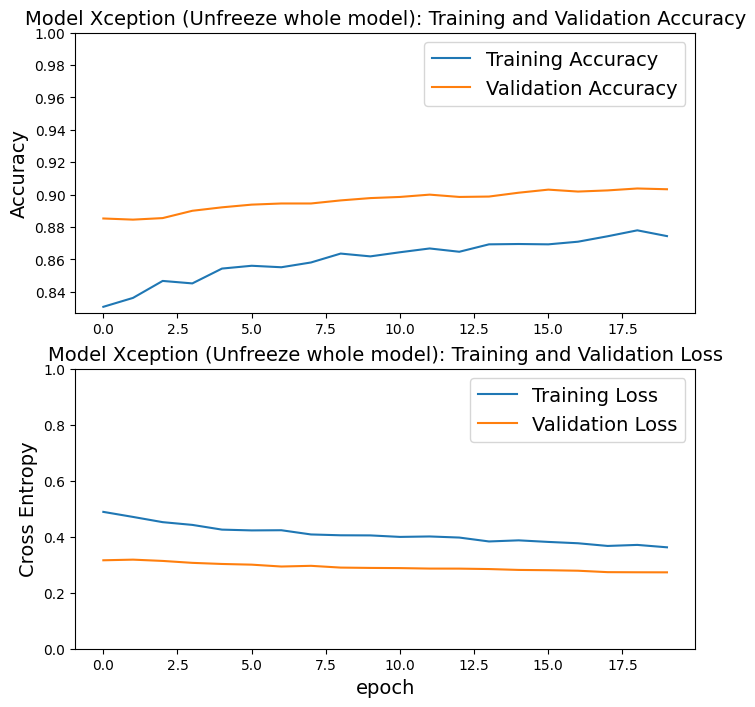

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Model Xception (Unfreeze whole model): Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Model Xception (Unfreeze whole model): Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Final test

In [ ]:
model.evaluate(test_ds)

# It has some improvement

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9029 - loss: 0.2804


[0.28721883893013, 0.9026666879653931]